<center><h1>Chapter 9</h1></center>

In this chapter I would like to look at using an ANN on a non-text problem. 

#1. Pima Indian Diabetes Study

The study of Diabetes within the Pima Indian population (roughly in area of borderlands of American Southwest and Mexico) started in 1965. There have been a number of separate research projects that are summarized in this 2015 paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4418458/.

We are going to be taking the look at one such study conducted in 1988: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf. The study was interested in  diagnostically predicting whether or not a patient will have diabetes onset within 5 years. Several constraints were placed on the selection of these instances from a larger database. In particular, all subjects  are females at least 21 years old and of Pima Indian heritage. The study chose to look at 8 features.



#2. Bring in libraries



In [0]:
#flush the old directory
!rm -r  'uo_puddles'

rm: cannot remove 'uo_puddles': No such file or directory


In [0]:
my_github_name = 'uo-puddles'  #replace with your account name

In [0]:
#clone_url = f'https://github.com/{my_github_name}/w20_ds_library.git'
clone_url = f'https://github.com/{my_github_name}/uo_puddles.git'

In [0]:
#get the latest.
!git clone $clone_url 


Cloning into 'uo_puddles'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 258 (delta 154), reused 64 (delta 33), pack-reused 0
Receiving objects: 100% (258/258), 66.97 KiB | 544.00 KiB/s, done.
Resolving deltas: 100% (154/154), done.


In [0]:
import uo_puddles.uo_puddles as up

#3. Pima dataset

In [0]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSUePrjXbJSrtSxEsw9fqEC1sz-0_hggsrJPDp6I98HbZOoCod5yNZCNkKJlXp-vmv4QbzFvuB2Y1LT/pub?output=csv'

In [0]:
import pandas as pd

pima_table = pd.read_csv(url,
                          encoding='utf-8')

In [0]:
len(pima_table)

768

In [0]:
pima_table.head(30)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


##Outcome column

The Outcome column is our label. A 1 signifies Diabetes onset within 5 years, a 0 no such onset.

Let's look at summary of the column.

In [0]:
pima_table['Outcome'].tolist().count(0)/768

0.6510416666666666

So our goal is to build a model that can predict at above 65% accuracy.

#4. Wrangle

By doing a bit of research, I found that a zero value in certain columns makes no sense. Kind of like having an age of zero. So we have to view these as wrong. They either were missing and someone entered a 0 to signify that, or they are just a typo. We don't really know which. But we will need to replace them.
The columns are ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age'].

I can use a pandas method to help, one that is not the useful for text problems but is for numeric problems.

First let's look a little more deeply on how are data is layed out.


In [0]:
pima_table.describe()  #Gives overview of numerical columns

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


##Trouble in River City

Some of the columns that I said should not have 0 values appear to have 0 values. Check out the min row. We are going to have to deal with that.

##Data imputation

Imputation is the fancy word for imputing or inferring the values where bogus values currently reside. There are different options. In the extreme case, we could make it a prediction problem in itself. This short paper gives an overview of alternative methods, including our good friend KNN as well as an ANN. https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

We will use something simple. Use the mean of a column to fill in bogus values in the column.

#Challenge 1
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

I won't call it an assignment because I'll work through the problem with you in class. The problem is (a) computing the mean of a column, while (b) making sure not to use bogus zeroes in the computation. If we just sum the column and divide by length, all those zeroes will look legit to sum function. Not good.

Let's do it for one column first, then think about writing a function to do it. Let's start with BloodPressure. I'd like the mean of this column and make sure I skip zeroes.

##Strategies

This is a bit of a tricky problem. Normally we would add up all the values in the column and then divide by the length of the column. The tricky part is the divisor. It won't likely be the length of the column because that includes zeroes.

I can see 2 strategies and I'll ask you to explore each with me.

###Strategy 1: for-loop

I am going to build up a list of all the non-zero values in the column. I can then sum that list and divide by its length.

This allows me to use my new list from old list gist.

In [0]:
# old list is pima_table

new_list = []
for i in range(len(pima_table)):
  item = pima_table.loc[i, 'BloodPressure']
  if item != 0:
    new_list.append(item)


In [0]:
the_mean = sum(new_list)/len(new_list)

In [0]:
the_mean  #72.40518417462484

72.40518417462484

###Strategy 2

Rely on existing methods to avoid writing a loop. Downside is that it will require googling.

Here is my first thought.

1. Find a way to add a pandas column. Get sum of BloodPressure column, including zeroes.

2. Find a way to count zeroes in a column. Count zeroes in BloodPressure column.

3. Divide sum by (length of column minus zero count).

That could work. But I also know that it is rare that the problem I am trying to solve is so unique that no one has ever had the same problem. Almost always false. So why not go for the gusto first? Try to state my general problem and see what I turn up. If that fails, I can go after individual pieces I have above.

Here is what I came up with for a google string of the big problem I am trying to solve:

<pre>
pandas mean non-zero values in column
</pre>

Let's try it out in other tab.

In [0]:
#x = df[df[A]!=0]
#x.mean()

x = pima_table[pima_table['BloodPressure'] != 0].mean()


What's up with the_mean? Looks kind of strange. Let's check its type.

In [0]:
type(x)

pandas.core.series.Series

In [0]:
the_mean = x
the_mean

Pregnancies                   3.855389
Glucose                     121.042292
BloodPressure                72.405184
SkinThickness                21.444748
Insulin                      83.609823
BMI                          32.292769
DiabetesPedigreeFunction      0.475861
Age                          33.361528
Outcome                       0.343793
dtype: float64

##pandas Series are weird

They sometimes act like a what is called a Python dictionary. You can give them a key and get a value. From above printout, looks like the keys are on the left and values on right. I'll try that next.

But to finish my thought, a pandas Series can also act like a list. So you can slice it. We were doing that early on to cut out certain columns in a row.

Treating it like a Python dictionary, let's see how it shakes out.

In [0]:
the_mean['BloodPressure']  #72.40518417462484

72.40518417462484

###What's the take home message?

Try your hand at googling first. There are 2 skills to learn. First, creating a search string that gets you viable answers. Second, sifting through those answers for ones that you can use. If you are successful, you can often find an existing method that replaces the need for you to write your own loop.

If googling doesn't get you anywhere, fall back on building your own loop.

##Aside: Also will see NaN for missing values

In fact, it is more common. NaN is a special pandas value. It is not a string. Going back to Chapter 2, you can see a NaN in the first row.

<img src='https://www.dropbox.com/s/lumqbu4d6tvwp6f/Screenshot%202020-05-24%2009.43.14.png?raw=1' height=100>

pandas has special methods for dealing with NaN values. I won't get side-tracked by those now, but if you see them in data you are working with, you will need to google something like "pandas handling NaN values".

#Challenge 2
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Now we have the mean for BloodPressure. Next up is filling the zero values with the mean.

While you could write a loop to do this, let's try the googling strategy first. Have to come up with good search string. What do you think? Let's go to other tab and try some out.

In [0]:
# df["column1"].replace({"a": "x", "b": "y"}, inplace=True)

pima_table['BloodPressure'].replace({0:the_mean['BloodPressure']}, inplace=True)

Did it work?


In [0]:
pima_table.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,72.405184,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,12.096346,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#Challenge 3
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Instead of copying and pasting above code for all the other columns, let's define a function to package it up.

So this is method 2 in the functions notebook: copy some code into function body then abstract it using parameters.

Here is the first step, copy and paste.

In [0]:
def replace_0_with_mean():

  the_mean = pima_table[pima_table['BloodPressure'] != 0].mean()
  pima_table['BloodPressure'].replace({0:the_mean['BloodPressure']}, inplace=True)


Choose one thing at a time. What is first thing that should be abstracted, i.e., parameterized?


In [0]:
def replace_0_with_mean(column):
  the_mean = pima_table[pima_table[column] != 0].mean()
  pima_table[column].replace({0:the_mean[column]}, inplace=True)


Ok, next thing.

In [0]:
def replace_0_with_mean(table, column):
  the_mean = table[table[column] != 0].mean()
  table[column].replace({0:the_mean[column]}, inplace=True)

Any others?

In [0]:
def replace_0_with_mean(table, column):
  the_mean = table[table[column] != 0].mean()
  table[column].replace({0:the_mean[column]}, inplace=True)

  return table

Last step, add the return value.

Test it first on Glucose. I can tell you the mean I got was 121.6867627785059. Here is before.

In [0]:
pima_table.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,72.405184,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,12.096346,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Now call the new function on Glucose.

In [0]:
pima_table = replace_0_with_mean(pima_table, 'Glucose')

In [0]:
pima_table.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#Challenge 4
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Write a loop that will call your function on the all the items in the list: `['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']`

In [0]:
pima_table.describe()

##Next up: shuffle

Before normalizing, let's shuffle the table.

In [0]:
import numpy as np
rsgen = np.random.RandomState(1234)  #use this so we get same values

In [0]:
shuffled_table = pima_table.sample(frac=1, random_state=rsgen).reset_index(drop=True)

In [0]:
shuffled_table.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,113.0,80.0,16,0,31.0,0.874,21,0
1,3,180.0,64.0,25,70,34.0,0.271,26,0
2,7,114.0,64.0,0,0,27.4,0.732,34,1
3,1,125.0,50.0,40,167,33.3,0.962,28,1
4,2,120.0,76.0,37,105,39.7,0.215,29,0


#Challenge 5: Normalize.
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Two steps: (1) drop columns that won't be part of the feature set. (2) Normalize remaining columns.

Anyone remember how to drop a column. Otherwise can google.

In [0]:
bare_table = 

In [0]:
bare_table.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0.567839,80.0,16,0,31.0,0.874,21,0
1,3,0.904523,64.0,25,70,34.0,0.271,26,0
2,7,0.572864,64.0,0,0,27.4,0.732,34,1
3,1,0.628141,50.0,40,167,33.3,0.962,28,1
4,2,0.603015,76.0,37,105,39.7,0.215,29,0


###Anyone remember how to normalize a column?

We can google if you do not.

In [0]:
# df["A"] = df["A"] / df["A"].max()

shuffled_table['Glucose'] = shuffled_table['Glucose']/shuffled_table['Glucose'].max()

##Being lazy

I'd rather not repeat this code for every column by hand. Let's write a loop to do it for us. First, I'd like to get all the column names in a list without copying and pasting or generating by hand.

Google! "pandas get column names"



###Now can write a loop

No need to google. We know how to write loops.

In [0]:
#Normalize all columns


In [0]:
bare_table.head()

#Challenge 6: pull out of pandas
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

We have done all that we are going to do with the values in the table. There are other actions possible, e.g., dealing with outliers. But we will stop here for now.




##Goal is list of lists

If I can set things up as a list of rows, where each row is a list of 8 values, then I am ready to feed it to an ANN.

Instead of writing a loop to do this, let's try googling first. How about this:

"pandas convert to list of lists"

In [0]:
pima_matrix = 

Check a few rows.

In [0]:
for i in range(3):
  print(pima_matrix[i])

[0.0, 0.5678391959798995, 0.6557377049180327, 0.16161616161616163, 0.18386314816814872, 0.4619970193740686, 0.36115702479338846, 0.25925925925925924]
[0.17647058823529413, 0.9045226130653267, 0.5245901639344263, 0.25252525252525254, 0.08274231678486997, 0.5067064083457526, 0.11198347107438017, 0.32098765432098764]
[0.4117647058823529, 0.5728643216080402, 0.5245901639344263, 0.2944789857913703, 0.18386314816814872, 0.40834575260804773, 0.30247933884297523, 0.41975308641975306]


##Train-Test split

I'll get you started so we are all using the same test set. Allows apples-to-apples comparison of your score to mine.

In [0]:
shuffled_labels = shuffled_table['Outcome'].tolist() #shuffled_table not pima_table
print(shuffled_labels[:10])

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


###Choosing 500 as split point

In [0]:
x_training = pima_matrix[:500]
y_training = shuffled_labels[:500]

x_testing = pima_matrix[500:]
y_testing = shuffled_labels[500:]

##For you KNN fans

Everything we have done so far, is also setting us up for KNN. You could use the training and testing data as fodder for KNN at this point.

But we will keep on with an ANN.

#Need a timing benchmark

Let's get a timing benchmark to give us an idea of how long training will take. So choose an architecture and let's go with 100 epochs to start.

In [0]:
layers = [4,2,1]  #using my binary split heuristic

In [0]:
m = up.ann_build_model(8, layers)

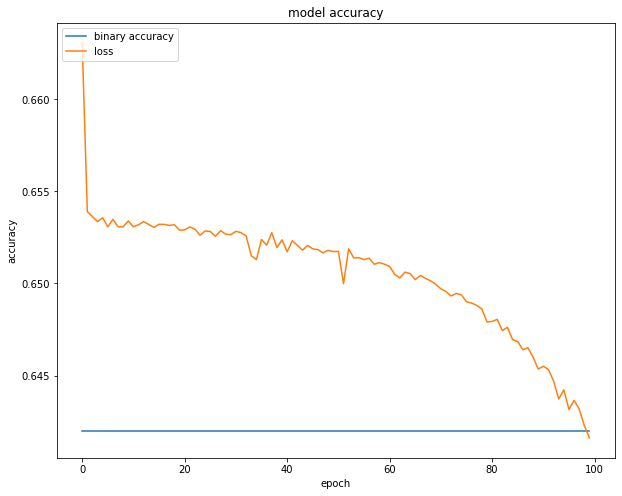

CPU times: user 59.6 s, sys: 5.24 s, total: 1min 4s
Wall time: 52.3 s


In [0]:
%%time

training = up.ann_train(m, x_training, y_training, 100)  #about a minute

In [0]:
training.history['binary_accuracy'][-10:]  #last accuracy:  .642

[0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235]

In [0]:
# calculate predictions
raw_predictions = m.predict(x_testing)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, y_testing))

(cases.count((0,0)) + cases.count((1,1)))/len(x_testing)  #.0.667910447761194

0.667910447761194

##What we have to beat

In [0]:
y_testing.count(0)/len(y_testing)  #0.667910447761194

0.667910447761194

I am guessing our model is simply always predicting 0 so end up matching above.

#Challenge 7: grid-search
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

This is a concept that is introduced in your midterm. So would like to spend some time with it here.

The general idea is that we can use a puddles function (which actually wraps a tensorflow bit of code) to try different combinations of layers (what I will call "architectures") and epochs. I'll show you and then discuss.

##Boredom alert!

I am not going to try for real on this problem. We will just be spinning our wheels in class waiting for everything to complete. So I will try with overly-small values for epochs.

First I'll use the new puddles function then explain.

In [0]:
#first set up alternatives

layer_choices = [[8,4,1], [8,1],[4,1]]  #notice a list of lists
epoch_choices = [10,20]

I'll start this up then discuss the concept of "batch" while we wait.

In [0]:
%%time

up.grid_search(layer_choices, epoch_choices, x_training, y_training, 8)  #features = 8

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1) ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1), total=   3.8s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1) ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1), total=   3.6s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1) ............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 4, 1), total=   3.7s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1) ...............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1), total=   3.4s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1) ...............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1), total=   3.8s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1) ...............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(8, 1), total=   3.7s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(4, 1) ...............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(4, 1), total=   3.7s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(4, 1) ...............
[CV]  batch_size=1, epochs=10, input_dim=8, lyrs=(4, 1), total=   3.7s
[CV] batch_size=1, epochs=10, input_dim=8, lyrs=(4, 1) ...............


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.6min finished


Best: 0.641957 using {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (8, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (4, 1)}
CPU times: user 1min 58s, sys: 9.38 s, total: 2min 8s
Wall time: 1min 40s


In [0]:
m = up.ann_build_model(8,[8,4,1])

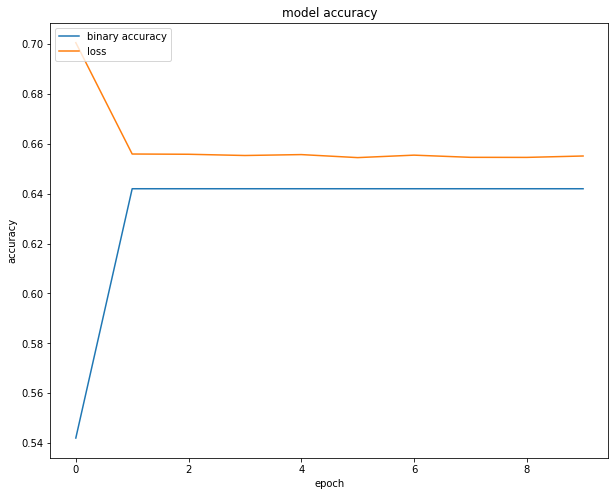

CPU times: user 6.42 s, sys: 410 ms, total: 6.83 s
Wall time: 5.38 s


In [0]:
%%time

training = up.ann_train(m, x_training, y_training, 10)

In [0]:
training.history['binary_accuracy'][-10:]  #last:  0.6420000195503235

[0.5419999957084656,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235,
 0.6420000195503235]

In [0]:
# calculate predictions
raw_predictions = m.predict(x_testing)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, y_testing))

(cases.count((0,0)) + cases.count((1,1)))/len(x_testing)  #0.667910447761194

0.667910447761194

##My results

I was able to get close to .8 by doing more exploring at higher epoch levels. I'll show you in a minute.

Now for explanation.

##Cross-validation

You can see below at the top of our output.

<pre>
Fitting 3 folds for each of 6 candidates, totalling 18 fits
</pre>

What the heck is a "fold"? And why 3 of them? I think it is easier to introduce the idea of cross-validation (CV) more broadly first. The general idea is that we do not want to wait until testing to see our results. We want to test during training! We don't touch the test set. It remains the gold-standard. Instead, we break off pieces of the training set as a "validation" set. It is bascially a test set used during training. Here is a picture.

<img src='https://i.imgur.com/9k60cVA.png'>

Why are there 5 rows, called Experiments in the diagram? We decided that we wanted to do this validation split 5 times. Where did 5 come from? Yet another hyperparameter.

How it works. I first divide up the training set into 5 folds. Each fold is just a slice of the traing data. So I'll have 5 slices.

Next, I build the model and train on slices 2 through 4 then test on slice 1. I remember the accuracy I got.

I repeat the process 4 more times, each time with a new model and a new slice I use for testing.

At the end, I average all 5 accuracies and that is my final result.

###`up.grid_search` uses 3 folds

It is a good default choice. If you want to change it, you can copy the function's code from uo-puddles and play around with different fold values. And a zillion other hyperparameters!

I think we can now interpret the results we got from grid_search. Here is what to pay attention to:

<pre>
Best: 0.641957 using {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (8, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 10, 'input_dim': 8, 'lyrs': (4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (8, 4, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (8, 1)}
0.641957 (0.024760) with: {'batch_size': 1, 'epochs': 20, 'input_dim': 8, 'lyrs': (4, 1)}
</pre>

You can see 6 results for the 6 cases we have by crossing architecture choices (3) with epoch choices (2). The number on the left is the average CV accuracy, i.e., the average after trying 3-folds on a combo. The number in parens is the standard deviation for the 3.

The best combo is shown at the top. It is semi-random in this case given that all the combos have the same average CV accuracy.

I know this is not very motivating because of the small epochs we are using. You will find it very useful when trying it for real.

##Just when you thought there could be no more hyperparameters

Wrong!

The way we take the folds is a choice. I am using simple CV where I just slice things up sequentially into folds. A more sophisticated approach would try to choose folds that carry the same distribution as the entire set. This is called "stratified" k-fold. See below.

<img src='https://i.stack.imgur.com/B9CCp.png'>

##My results

I did grid search and came up with [4,3,1] as a good architecture. And 900 epochs as a good choice. Unfortunately, this took me 10 minutes to train. So won't be running live in class. But I can show you my results.

In [0]:
m = up.ann_build_model(8,[4,3,1])

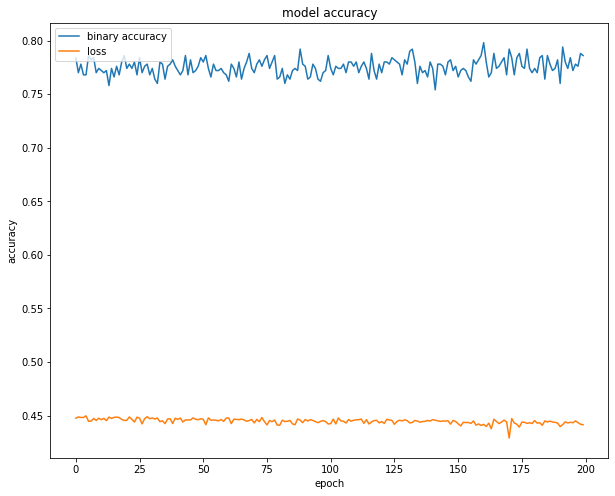

CPU times: user 1min 59s, sys: 9.43 s, total: 2min 9s
Wall time: 1min 40s


In [0]:
%%time

training = up.ann_train(m, x_training, y_training, 900)

In [0]:
training.history['binary_accuracy'][-10:]  #last:  0.7860000133514404

[0.7599999904632568,
 0.7940000295639038,
 0.7799999713897705,
 0.7739999890327454,
 0.7839999794960022,
 0.7720000147819519,
 0.777999997138977,
 0.7760000228881836,
 0.7879999876022339,
 0.7860000133514404]

In [0]:
# calculate predictions
raw_predictions = m.predict(x_testing)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, y_testing))

(cases.count((0,0)) + cases.count((1,1)))/len(x_testing)  #0.7947761194029851

0.7947761194029851

##The confusion matrix

In [0]:
print(f'false positive: {cases.count((1,0))}')
print(f'false negative: {cases.count((0,1))}')

false positive: 22
false negative: 33


##What's the cost of being wrong?

Let's say that a positive outcome leads to the person being put on a special diet and set of drugs. Diet might be costly. Drugs might have side-effects.

* False positive cost: unneeded treatment.
* False negative cost: miss chance to treat.

How could we shift away from false negative? Remember the network output is a value between 0 and 1.

Maybe we are overfitting. I'll try reducing the epochs.



In [0]:
m = up.ann_build_model(8,[4,3,1])

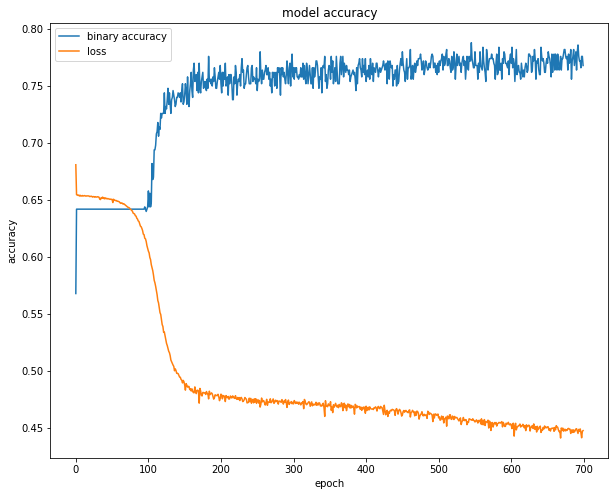

CPU times: user 6min 48s, sys: 34.8 s, total: 7min 23s
Wall time: 5min 47s


In [0]:
%%time

training = up.ann_train(m, x_training, y_training, 700)  #6 minutes

In [0]:
training.history['binary_accuracy'][-10:]  #last:  0.7680000066757202

[0.7639999985694885,
 0.7799999713897705,
 0.7860000133514404,
 0.7760000228881836,
 0.7720000147819519,
 0.7720000147819519,
 0.765999972820282,
 0.7760000228881836,
 0.7760000228881836,
 0.7680000066757202]

In [0]:
# calculate predictions
raw_predictions = m.predict(x_testing)
predictions = [int(round(x[0])) for x in raw_predictions]
cases = list(zip(predictions, y_testing))

(cases.count((0,0)) + cases.count((1,1)))/len(x_testing)  #0.7611940298507462

0.7611940298507462

##New confusion matrix

In [0]:
print(f'false positive: {cases.count((1,0))}')
print(f'false negative: {cases.count((0,1))}')

false positive: 43
false negative: 21


##Tough Choice!

We dropped overall accuracy by 3 percentage points. But we also reduced the false negative count by 30%.

#End notes

* I've seen .83 using an ANN on this problem. Changes our default values for hyperparameters.

* Best I have seen for KNN on this problem is 0.765625.

* SVM: .81.

* Regression 0.807291666667.

* Decision tree .90. Caveat: missing details of how model built.

